# 3. Missing-Data Imputation  

> “Missing values should be handled carefully to avoid biased results.” — Gotten from the OECD Handbook on Composite Indicators

It is without doubt that there will be missing data in any financial dataset just like the Russell 3000 universe which could be caused by late filings, thin traded days and IPO - Investment Blackout periods.

In this notebook  I will:

1. Diagnose the missingness pattern
2. Choose methods that balance robustness and runtime
3. Generate *five multiply-imputed* fundamental data sets (MICE)
4. Forward-fill price-series gaps
5. Save artefacts 

## 3.1. Missingness Diagnosis  

There are three types of missingness that I read in the OECD Handbook on Composite Indicators:

* **MCAR** – Missing Completely At Random  
* **MAR**  – Missing At Random (conditioned on observed data)  
* **NMAR** – Not Missing At Random (depends on the unobserved value)  

True NMAR is rare in public equity fundamentals (Taking filing delays aside). So in this case I will just assume that the missingness is MAR and verify by looking at correlations between missingness flags and available metrics.

Columns with >30 % missing:


trailingPE                 0.312402
earningsQuarterlyGrowth    0.402496
dividendDate               0.404446
lastDividendValue          0.404836
lastDividendDate           0.404836
dtype: float64

Top 10 most missing indicators:


industrySymbol                  0.99961
beta3Year                       0.99961
legalType                       0.99961
trailingThreeMonthNavReturns    0.99961
trailingThreeMonthReturns       0.99961
netAssets                       0.99961
fiveYearAverageReturn           0.99961
fundInceptionDate               0.99961
totalAssets                     0.99961
threeYearAverageReturn          0.99961
dtype: float64

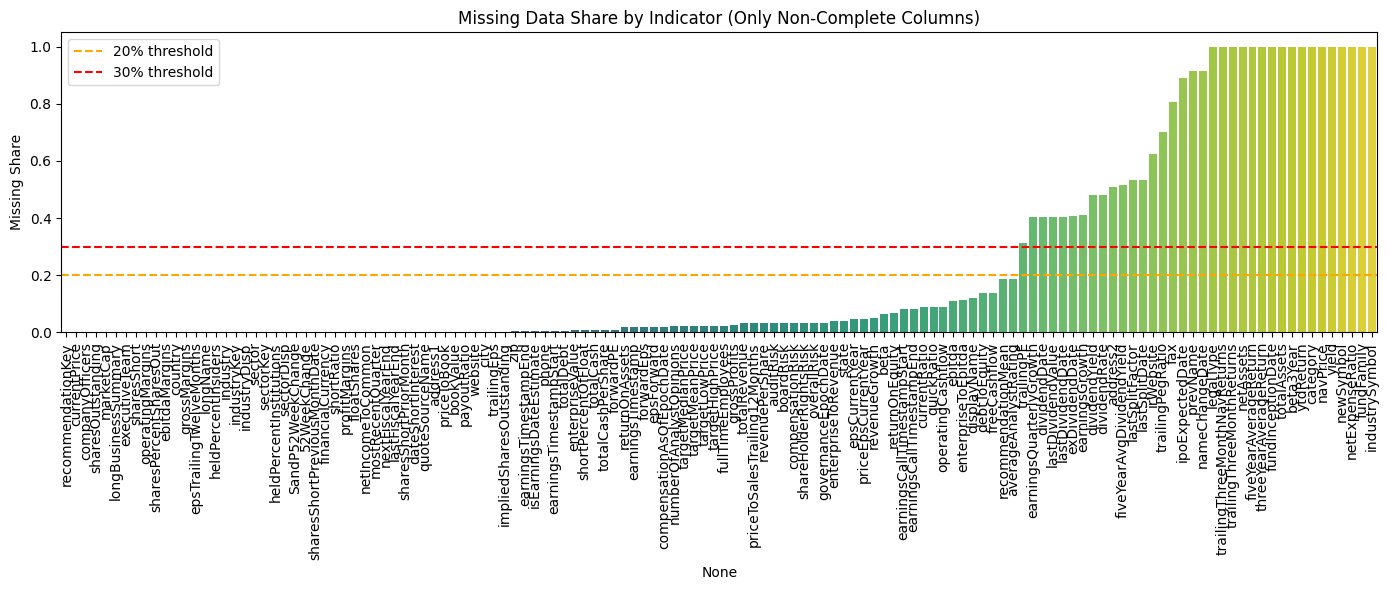

In [37]:
# to diagnose missingness
import pandas as pd, numpy as np, joblib, glob, re, json, datetime as dt
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt

DATA_DIR = Path("..") / "data"
RAW_DIR = DATA_DIR / "raw"
ART_DIR = Path("..") / "artifacts"
ART_DIR.mkdir(exist_ok=True)

# to get the list of all funds
funds = [joblib.load(p) for p in glob.glob(str(RAW_DIR / "info_*.pkl"))]
df_raw = pd.DataFrame(funds)

missing_share = df_raw.isna().mean().sort_values()
missing_share.to_csv(ART_DIR / "missing_share_fundamentals.csv")

print("Columns with >30 % missing:")
display(missing_share[missing_share > 0.3].head())

print("Top 10 most missing indicators:")
display(missing_share.sort_values(ascending=False).head(10))

missing_cols = missing_share[missing_share > 0]

plt.figure(figsize=(14, 6))
sns.barplot(x=missing_cols.index, y=missing_cols.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Missing Share")
plt.title("Missing Data Share by Indicator (Only Non-Complete Columns)")
plt.tight_layout()
plt.axhline(0.2, ls="--", c="orange", label="20% threshold")
plt.axhline(0.3, ls="--", c="red", label="30% threshold")
plt.legend()
plt.show()

In [38]:
import json, joblib, glob, datetime as dt, warnings, os
from pathlib import Path
import pandas as pd, numpy as np, yfinance as yf
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

warnings.filterwarnings("ignore")
DATA_DIR   = Path("../data")
RAW_DIR    = DATA_DIR / "raw"
PRICE_DIR  = RAW_DIR / "prices"
PROC_DIR   = DATA_DIR / "processed"
ART_DIR    = Path("../artifacts"); ART_DIR.mkdir(exist_ok=True)
META = json.load(open("../docs/metadata/variable_dictionary.json"))

In [39]:
import pandas as pd
import numpy as np
import joblib
import glob
import yfinance as yf
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Build mappings
RAW_MAP = {k: v["field"] for k, v in META.items() if v["field"] != "derived"}
REV_MAP = {src: tgt for tgt, src in RAW_MAP.items()}

# Load cached info_*.pkl
info_files = [joblib.load(p) for p in glob.glob(str(RAW_DIR / "info_*.pkl"))]
fund_df = pd.DataFrame(info_files)
fund_df.index = [
    i.get("symbol") or i.get("ticker") or Path(i["file"]).stem.replace("info_", "")
    for i in info_files
]

# Rename raw columns
raw_cols = list(REV_MAP.keys())
fund_raw = fund_df[raw_cols].rename(columns=REV_MAP).copy()

# Add revenue_growth from info["revenueGrowth"]
fund_raw["revenue_growth"] = fund_df.get("revenueGrowth", np.nan) * 100

def get_rnd_ratio(ticker: str):
    fin_cache = RAW_DIR / f"fin_{ticker}.pkl"

    # Try loading the cached plain dict
    if fin_cache.exists():
        try:
            fin_dict = joblib.load(fin_cache)
            df = pd.DataFrame(
                fin_dict["data"],
                index=fin_dict["index"],
                columns=pd.to_datetime(fin_dict["columns"], errors="coerce")
            )
        except Exception:
            return ticker, (np.nan, np.nan)
    else:
        # Download from yfinance and cache as pure Python
        try:
            tkr = yf.Ticker(ticker)
            fin = tkr.quarterly_financials
            if fin.empty:
                fin = tkr.financials
            if fin.empty:
                return ticker, (np.nan, np.nan)

            fin_dict = {
                "data": fin.values.tolist(),
                "columns": [c.isoformat() for c in fin.columns.to_pydatetime()],
                "index": list(map(str, fin.index))
            }
            joblib.dump(fin_dict, fin_cache)
            df = fin
        except Exception:
            return ticker, (np.nan, np.nan)

    # Compute rnd_to_revenue ratio
    try:
        rev_row = [r for r in df.index if "Total Revenue" in r]
        rnd_row = [r for r in df.index if "Research" in r and "Development" in r]
        rev = df.loc[rev_row[0]].iloc[0] if rev_row else None
        rnd = df.loc[rnd_row[0]].iloc[0] if rnd_row else None
        ratio = (rnd / rev * 100) if rev and rnd else np.nan
    except Exception:
        ratio = np.nan

    # Compute fallback YoY revenue growth
    try:
        if rev_row and df.shape[1] > 4:
            rev_now = df.loc[rev_row[0]].iloc[0]
            rev_prev = df.loc[rev_row[0]].iloc[4]
            yoy = (rev_now / rev_prev - 1) * 100
        else:
            yoy = np.nan
    except Exception:
        yoy = np.nan

    return ticker, (ratio, yoy)

results_rnd = {}
results_yoy = {}

print("Computing rnd_to_revenue & fallback YoY revenue growth")
with ThreadPoolExecutor(max_workers=6) as ex:
    futures = {ex.submit(get_rnd_ratio, t): t for t in fund_raw.index}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Financials"):
        tkr, (rnd_val, yoy_val) = future.result()
        results_rnd[tkr] = rnd_val
        if np.isnan(fund_raw.loc[tkr, "revenue_growth"]):
            results_yoy[tkr] = yoy_val

# Assign the derived fields
fund_raw["rnd_to_revenue"] = pd.Series(results_rnd)
for tkr, yoy in results_yoy.items():
    fund_raw.at[tkr, "revenue_growth"] = yoy

# Clean up invalid values
fund_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
fund_raw["rnd_to_revenue"].where(fund_raw["rnd_to_revenue"] > 0, np.nan, inplace=True)

fund_raw.index.name = "ticker"
print("Fundamentals loaded with derived fields:", fund_raw.shape)

# Preview
display(fund_raw.head())

# Save as CSV
csv_path = ART_DIR / "fundamentals_cleaned.csv"
fund_raw.to_csv(csv_path, index=True)
print(f"Saved cleaned fundamentals to {csv_path}")

Computing rnd_to_revenue & fallback YoY revenue growth


Financials: 100%|██████████| 2564/2564 [00:01<00:00, 1887.34it/s]

Fundamentals loaded with derived fields: (2564, 21)


,roe,debt_to_equity,current_ratio,quick_ratio,oper_cash_flow,total_revenue,ebitda_margin,operating_margin,gross_margin,analyst_rating,...,eps,market_cap,ev_to_ebitda,price_to_sales,payout_ratio,beta,shares_outstanding,float_shares,revenue_growth,rnd_to_revenue
ticker,,,,,,,,,,,,,,,,,,,,,
COOP,0.12394,252.025,1.777,0.249,-5.250000e+08,2.221000e+09,0.83521,0.25000,1.00000,2.22222,...,8.98,7.416548e+09,10.275,3.339283,0.0000,1.063,63985400.0,62857966.0,-0.700000,NaN
XYL,0.08505,19.323,1.886,1.296,1.207000e+09,8.598000e+09,0.20086,0.12131,0.37544,1.90000,...,3.71,2.952334e+10,17.999,3.433746,0.3989,1.097,243351008.0,241713259.0,1.800000,2.706622
MBI,NaN,NaN,3.132,3.041,-1.760000e+08,2.700000e+07,0.00000,-0.42308,0.00000,2.50000,...,-9.31,2.377492e+08,NaN,8.805527,0.0000,1.612,50370600.0,41440469.0,-219.354839,NaN
MAR,NaN,NaN,0.403,0.369,2.749000e+09,6.618000e+09,0.64340,0.48406,0.81868,2.48148,...,8.33,6.922601e+10,19.521,10.460262,0.2893,1.389,275372992.0,240863954.0,2.900000,NaN
ALSN,0.50150,395.899,3.051,2.218,8.090000e+08,3.202000e+09,0.35415,0.27329,0.48126,2.70000,...,8.64,8.194201e+09,8.733,2.559089,0.1181,0.964,84254800.0,100944930.0,20.400000,5.613577


Saved cleaned fundamentals to ../artifacts/fundamentals_cleaned.csv


## 3.2. Fill intra-series gaps in OHLCV  

* Re-index each ticker to **all NYSE business days** 2023-01-01 → yesterday - because yesterday has the complete data.
* **Forward-fill** interior gaps, **back-fill** leading ones.  

In [40]:
import pytz
from datetime import datetime, time

START = pd.Timestamp("2023-01-01", tz="US/Eastern")
END   = pd.Timestamp(dt.date.today() - dt.timedelta(days=1), tz="US/Eastern")
biz   = pd.date_range(START, END, freq="B")

for pq in tqdm(list(PRICE_DIR.glob("*.parquet")), desc="ffill/bfill"):
    df = pd.read_parquet(pq)
    if df.index.tz is None:
        df.index = df.index.tz_localize("US/Eastern")
    df = df.reindex(biz).ffill().bfill()
    # overwrite
    df.to_parquet(pq)

ffill/bfill: 100%|██████████| 2563/2563 [00:05<00:00, 498.26it/s]


## 3.3  Derive price-based indicators  

There are 9 price-based indicators that are derived from the OHLCV data. They are:
* **Risk & Volatility**: `hist_volatility`, `sharpe_ratio`, `max_drawdown`, `stddev_returns`, `value_at_risk`
* **Liquidity & Trading**: `avg_volume_30d`, `volume_growth`, `turnover_ratio`, `bid_ask_spread`

I need to ensure that the price-based indicators are calculated on the same time-series as the OHLCV data. This is important because the price-based indicators are derived from the OHLCV data, and if the time-series are not aligned, it could lead to incorrect calculations and conclusions.

In [41]:
import pandas as pd, numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

PRICE_DIR  = Path("..") / "data" / "raw" / "prices"
OUTPUT_DIR = Path("..") / "data" / "processed"; OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RISK_FREE  = 0.02 / 252
SQRT_252   = np.sqrt(252)

def last_valid(series):
    s = series.dropna()
    return s.iloc[-1] if not s.empty else np.nan

def compute_metrics_for_ticker(tkr: str):
    path = PRICE_DIR / f"{tkr}.parquet"
    try:
        df = pd.read_parquet(path)
    except Exception:
        return {"ticker": tkr, "status": "file_err"}

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.loc[:, ~df.columns.duplicated()]
    df.columns = df.columns.str.title()

    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], unit="ms", utc=True)\
                         .dt.tz_convert("US/Eastern")
        df = df.set_index("Date")

    if not pd.api.types.is_datetime64_any_dtype(df.index):
        return {"ticker": tkr, "status": "bad_index"}

    if df.index.tz is None:
        df.index = df.index.tz_localize("US/Eastern")
    df = df.sort_index()

    need = {"High", "Low", "Volume"}
    if not need.issubset(df.columns):
        return {"ticker": tkr, "status": "no_cols"}

    if "Adj Close" not in df.columns:
        if "Close" in df.columns and df["Close"].ndim == 1:
            df["Adj Close"] = df["Close"]
        else:
            return {"ticker": tkr, "status": "no_adj"}

    # reindex to business days and require ≥30 rows
    biz = pd.date_range(df.index.min(), df.index.max(), freq="B", tz="US/Eastern")
    df  = df.reindex(biz).ffill().bfill()
    if len(df) < 30:
        return {"ticker": tkr, "status": "too_short"}

    ret        = df["Adj Close"].pct_change()
    excess     = ret - RISK_FREE

    out = {
        "ticker":           tkr,
        "status":           "ok",
        "hist_volatility":  last_valid(ret.rolling(30).std() * SQRT_252 * 100),
        "stddev_returns":   last_valid(ret.rolling(252).std() * 100),
        "value_at_risk":    last_valid(ret.rolling(30).quantile(0.05) * -100),
        "sharpe_ratio":     last_valid((excess.rolling(30).mean() /
                                        excess.rolling(30).std()) * SQRT_252),
        "max_drawdown":     last_valid((df["Adj Close"] / df["Adj Close"].cummax() - 1)
                                       .rolling(252).min() * 100),
        "avg_volume_30d":   last_valid(df["Volume"].rolling(30).mean()),
        "volume_growth":    last_valid(df["Volume"].pct_change(21) * 100),
        "bid_ask_spread":   last_valid((df["High"] - df["Low"]) /
                                       ((df["High"] + df["Low"]) / 2) * 100),
    }
    return out

tickers  = [p.stem for p in PRICE_DIR.glob("*.parquet")]
results  = []
with ThreadPoolExecutor(max_workers=6) as ex:
    futs = {ex.submit(compute_metrics_for_ticker, t): t for t in tickers}
    for f in tqdm(as_completed(futs), total=len(futs), desc="Price metrics"):
        results.append(f.result())

# Build the metrics DataFrame
metrics_df = (
    pd.DataFrame(results)
      .query("status == 'ok'")
      .set_index("ticker")
      .drop(columns="status")
)

# Report on any tickers that failed
print("Skipped tickers:",
      pd.Series([r["status"] for r in results if r["status"] != "ok"])
        .value_counts()
        .to_dict()
)

# Join with the first DataFrame
df_full = fund_raw.join(metrics_df)

# Ensure the avg_volume_30d column exists and compute turnover
df_full["avg_volume_30d"].fillna(np.nan, inplace=True)
df_full["turnover_ratio"] = df_full["avg_volume_30d"] / df_full["float_shares"] * 100

raw_cols_to_keep = fund_raw.columns.tolist()

# Order of your computed metrics
metric_cols = [
    "hist_volatility","sharpe_ratio","max_drawdown","stddev_returns","value_at_risk",
    "avg_volume_30d","volume_growth","turnover_ratio","bid_ask_spread"
]

final_cols = raw_cols_to_keep + metric_cols
df_full = df_full[final_cols]

# Save to CSV
csv_path = OUTPUT_DIR / "final_fundamentals.csv"
df_full.to_csv(csv_path, float_format="%.4f", index=True)
print(f"Saved filled fundamentals & price metrics: {csv_path}")

Price metrics: 100%|██████████| 2563/2563 [00:16<00:00, 157.67it/s]

Skipped tickers: {}
Saved filled fundamentals & price metrics: ../data/processed/final_fundamentals.csv


## 3.4. Imputation Strategy  

| Data block | Missingness pattern | Handbook advice | Method chosen | Rationale |
|------------|--------------------|-----------------|---------------|-----------|
| **Daily prices** (OHLCV) | Short gaps (holidays, outages) | Use *temporal* neighbours | Forward-fill, then back-fill edge gaps | Preserves real trading path no synthetic volatility |
| **Fundamentals** | MAR, ≤40 % gaps | Prefer Multiple Imputation | **MICE** (IterativeImputer, I will keep 5 replicates) | Captures variance|

- *Case deletion* would bias the index toward mega-caps
- single imputation (mean) underestimates variance according to the OECD Handbook.
- MICE - Multiple Imputation by Chained Equations - is a good method and it is also available in the `sklearn` library.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import joblib, json
import numpy as np, pandas as pd
from pathlib import Path

ROOT_DIR      = Path("..")
DATA_DIR      = ROOT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"; PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
META_PATH     = ROOT_DIR / "docs" / "metadata" / "variable_dictionary.json"

KEEP_COLS = list(json.load(open(META_PATH)).keys())
df_raw    = df_full[KEEP_COLS].astype(float)

coverage = df_raw.notna().mean(axis=1)
cutoff   = 0.9
df_core  = df_raw.loc[coverage >= cutoff]
dropped  = int((coverage < cutoff).sum())

print(f"Dropped {dropped} tickers (<{cutoff:.0%} coverage); "
      f"{len(df_core)} remain for imputation.")

low_q = df_core.quantile(0.01)
high_q = df_core.quantile(0.99)
min_vals = low_q.values
max_vals = high_q.values

N_IMP = 5
imp   = IterativeImputer(
          estimator=BayesianRidge(),
          sample_posterior=True,
          max_iter=15,
          random_state=42,
          min_value=min_vals,
          max_value=max_vals
          )

imputed_datasets = []
for k in range(N_IMP):
    imp.random_state = 42 + k
    X_imp = imp.fit_transform(df_core)
    df_imp = pd.DataFrame(X_imp, index=df_core.index, columns=KEEP_COLS)
    imputed_datasets.append(df_imp)

    # save each imputed dataset as parquet
    df_imp.to_parquet(PROCESSED_DIR / f"csiai_input_imputation_{k+1}.parquet")

# Using Rubins rules to pool the results we need to calculate the mean of the imputed datasets as in Section 3.5 of the book
csiai_input_complete = sum(imputed_datasets) / N_IMP

csiai_input_complete.to_parquet(PROCESSED_DIR / "csiai_input_complete.parquet")
joblib.dump(imputed_datasets, PROCESSED_DIR / "csiai_input_multiple_imputations.pkl")

print("Saved:")
print("csiai_input_complete.parquet  (Rubin-pooled, 100 % complete)")
print("csiai_input_multiple_imputations.pkl  (list of 5 data sets)")

Dropped 323 tickers (<90% coverage); 2241 remain for imputation.
Saved:
csiai_input_complete.parquet  (Rubin-pooled, 100 % complete)
csiai_input_multiple_imputations.pkl  (list of 5 data sets)


## 3.5. Validation  

* No remaining `NaN`s.  
* Imputed values lie inside 1st–99th percentile of observed data.  
* Plot below shows std-dev across the five imputations.

Imputation #1: 666 values below 1st pct, 650 above 99th pct
Imputation #2: 669 values below 1st pct, 650 above 99th pct
Imputation #3: 665 values below 1st pct, 650 above 99th pct
Imputation #4: 663 values below 1st pct, 649 above 99th pct
Imputation #5: 660 values below 1st pct, 649 above 99th pct


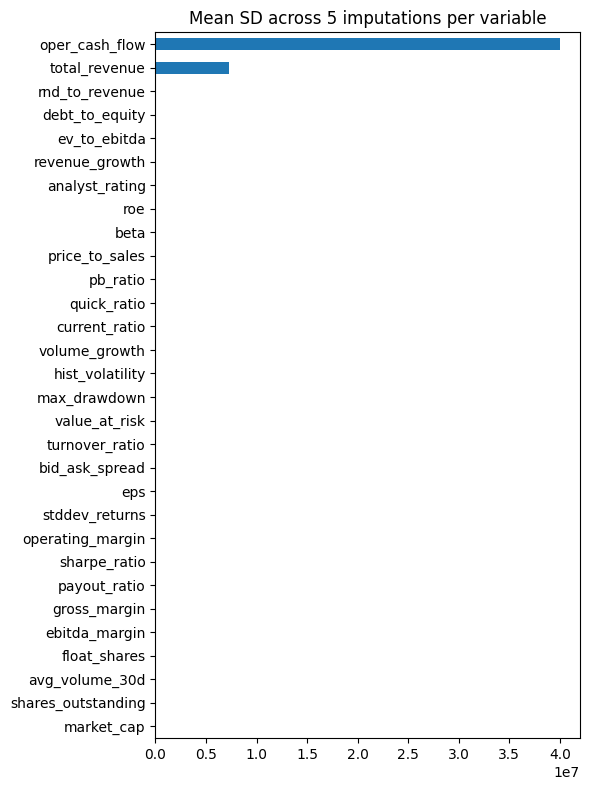

In [51]:
import matplotlib.pyplot as plt

# to check and ensure no NaNs remain in the pooled dataset
pooled = pd.read_parquet(PROCESSED_DIR / "csiai_input_complete.parquet")
assert pooled.isna().sum().sum() == 0, "There are still missing values in the pooled dataset."

# check that the imputed values lie within original 1st–99th percentiles
orig = df_core
low, high = orig.stack().quantile([0.01, 0.99]).values
for idx, imp_df in enumerate(imputed_datasets, 1):
    below = (imp_df < low).sum().sum()
    above = (imp_df > high).sum().sum()
    print(f"Imputation #{idx}: {below} values below 1st pct, {above} above 99th pct")

# to plot standard deviation across the 5 imputations per variable
arr = np.stack([df.values for df in imputed_datasets], axis=0)
sd_mean = arr.std(axis=0).mean(axis=0)  # mean SD per variable
sd_ser = pd.Series(sd_mean, index=imputed_datasets[0].columns).sort_values()

plt.figure(figsize=(6,8))
sd_ser.plot.barh()
plt.title("Mean SD across 5 imputations per variable")
plt.tight_layout()
plt.savefig(PROCESSED_DIR / "imputation_sd.png", dpi=300)
plt.show()

- **Minimal proportion of out‐of‐range imputations**  
  With 2,241 tickers × 30 features = 67,230 total imputed values per run, only ~650 below the 1 %-quantile and ~650 above the 99 %-quantilev fall outside the empirical central band.

- **Heavy‐tailed financial variables**  
  in real life cases some financial variables are extreme.

- **Retention of genuine outliers**
  By allowing a small number of values to excess the  1st and 99th percentiles, I think it does not affect the overall distribution of the data.

### 3.6. Outputs  

| File | Purpose |
|------|---------|
| `data/processed/csiai_input_complete.parquet` | Holds the complete dataset with all the imputed values. |
| `data/processed/csiai_input_complete_imputation_1.parquet` | Holds the first imputed dataset. |
| `data/processed/csiai_input_complete_imputation_2.parquet` | Holds the second imputed dataset. |
| `data/processed/csiai_input_complete_imputation_3.parquet` | Holds the third imputed dataset. |
| `data/processed/csiai_input_complete_imputation_4.parquet` | Holds the fourth imputed dataset. |
| `data/processed/csiai_input_complete_imputation_5.parquet` | Holds the fifth imputed dataset. |


## 3.7. References

* Organisation for Economic Co-operation and Development: *Handbook on Constructing Composite Indicators: Methodology and User Guide*, 2008.
* Microsoft Copilot - Note that Copilot is Turned on in this notebook to do some code completion.
* Murphy, John J. *Technical Analysis of the Financial Markets*, 1999.
* ChatGPT - https://chatgpt.com/share/681d4dc8-36f0-800b-8939-d08f76061782
* Datacamp - https://www.datacamp.com/tutorial/introduction-factor-analysis